In [41]:
!pip install yfinance mplfinance pmdarima sktime

^C
ERROR: Operation cancelled by user


In [42]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [51]:
ticker = "FPT.VN"
start_date = "2014-01-01"
end_date = "2024-09-01"
data = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [60]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 
check(data)

,column,dtypes,nunique,sum_null
0,Open,float64,1281,0
1,High,float64,1305,0
2,Low,float64,1316,0
3,Close,float64,1333,0
4,Adj Close,float64,1333,0
5,Volume,int64,2653,0


In [52]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,9430.621094,9470.245117,9351.372070,9390.996094,9193.407227,1047167
2014-01-03,9371.184570,9390.996094,9311.747070,9371.184570,9174.011719,984788
2014-01-06,9371.184570,9509.870117,9311.747070,9509.870117,9309.780273,1522633
2014-01-07,9509.870117,9509.870117,9410.808594,9410.808594,9212.802734,1468728
2014-01-08,9390.996094,9509.870117,9390.996094,9470.245117,9270.988281,654134


In [61]:
data.describe().T.apply(lambda x: x.apply("{0:.3f}".format))

,count,mean,std,min,25%,50%,75%,max
Open,2657.000,35918.104,28310.070,9371.185,14148.903,22523.613,58664.145,139100.000
High,2657.000,36318.892,28642.459,9390.996,14279.911,22862.598,59168.242,139700.000
Low,2657.000,35552.208,28004.120,9311.747,13992.387,22298.377,58071.832,137500.000
Close,2657.000,35933.902,28333.928,9371.185,14116.213,22523.613,58664.145,139600.000
Adj Close,2657.000,35325.863,28115.747,9174.012,13819.204,22049.709,57429.832,139600.000
Volume,2657.000,3833465.365,3361528.980,292272.000,1812332.000,2981710.000,4857369.000,76621636.000


In [53]:
df_close = data['Close']

<Axes: ylabel='Density'>

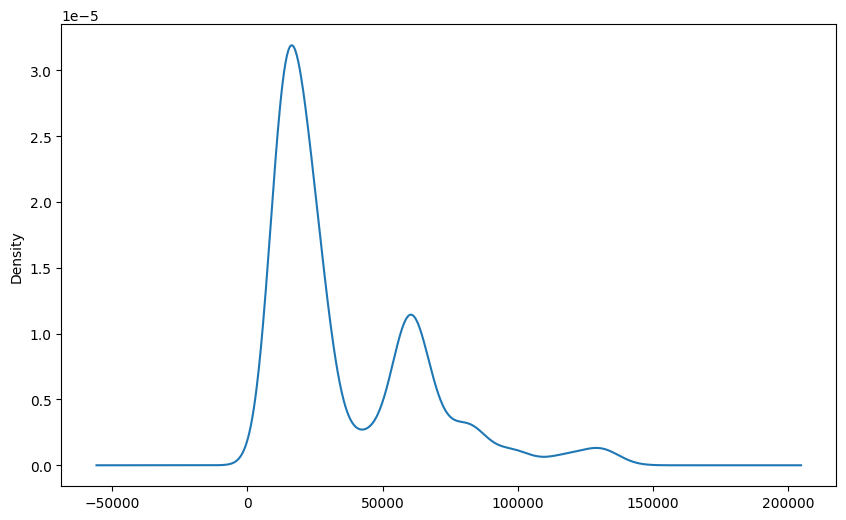

In [54]:
df_close.plot(kind='kde')

In [55]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

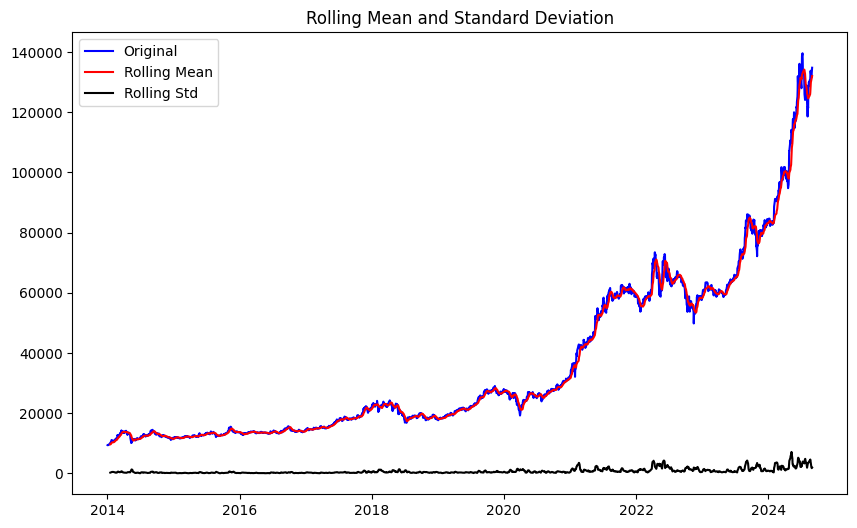

Results of dickey fuller test
Test Statistics                   3.448014
p-value                           1.000000
No. of lags used                 27.000000
Number of observations used    2629.000000
critical value (1%)              -3.432840
critical value (5%)              -2.862640
critical value (10%)             -2.567356
dtype: float64


In [56]:
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

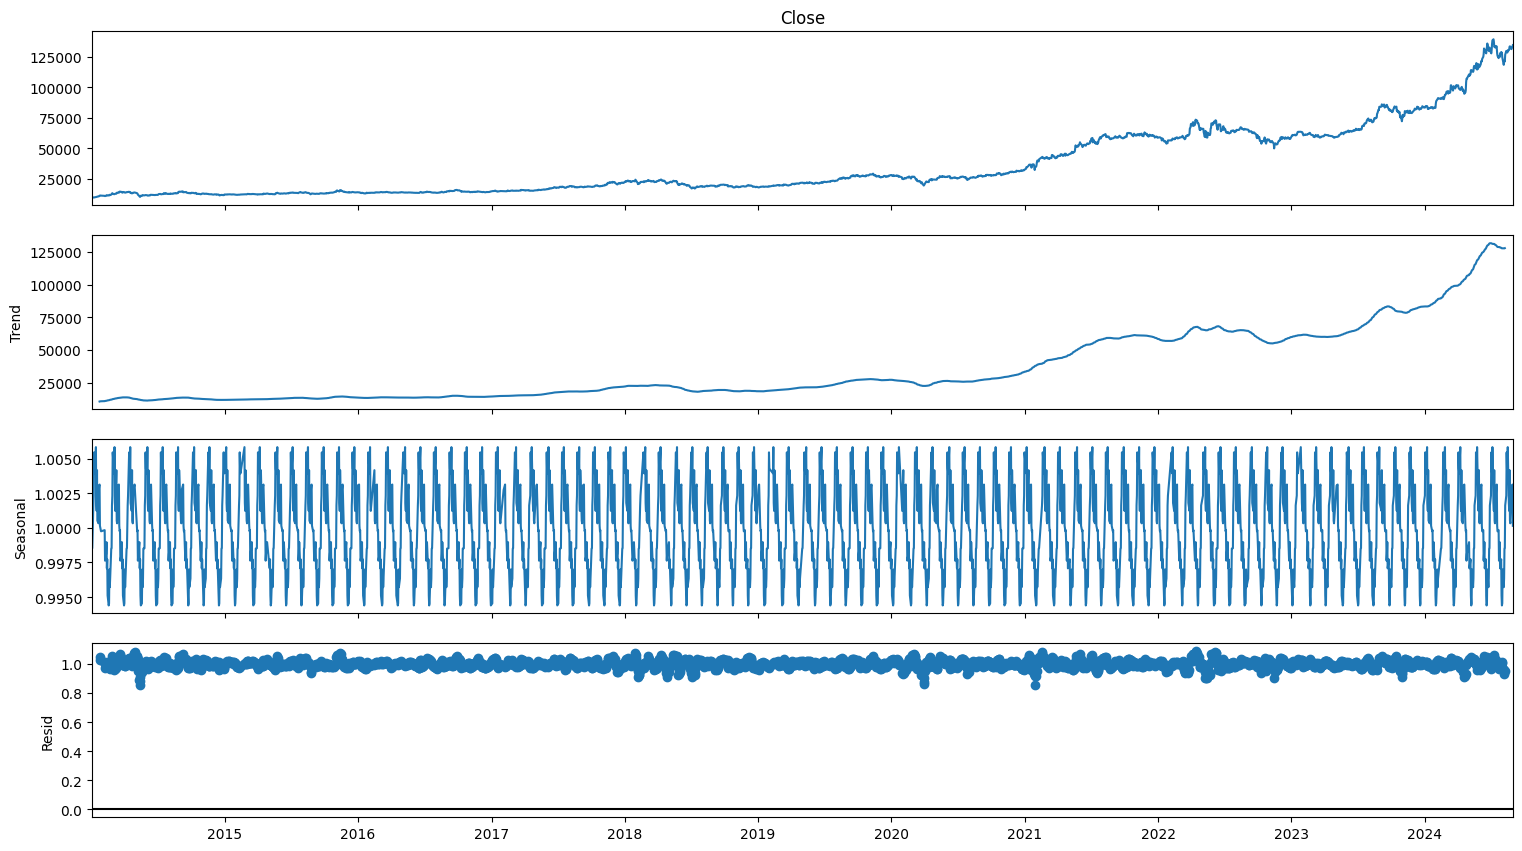

In [57]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

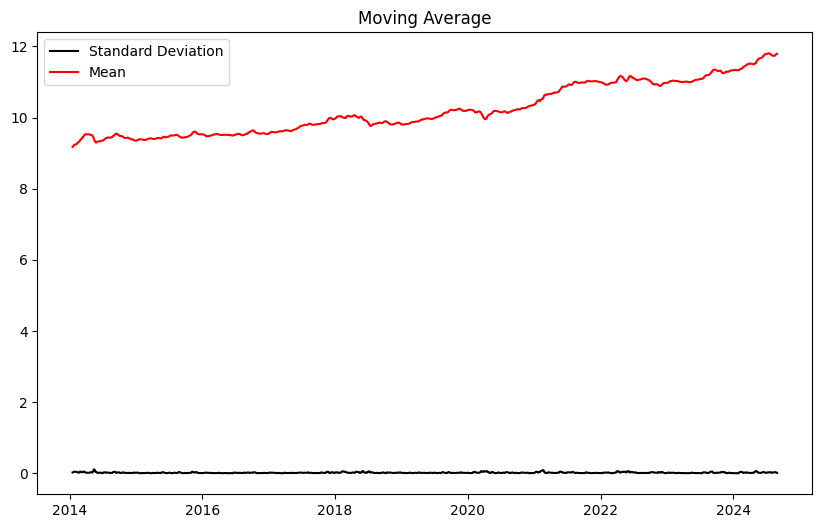

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [64]:
length = int(len(df_close) * 0.90)
print('Length:', length)
print('Data length:',len(data))
train = df_close.iloc[:length]
print('training shape',train.shape)
test = df_close.iloc[length:]
print('testing shape',test.shape)

Length: 2391
Data length: 2657
training shape (2391,)
testing shape (266,)


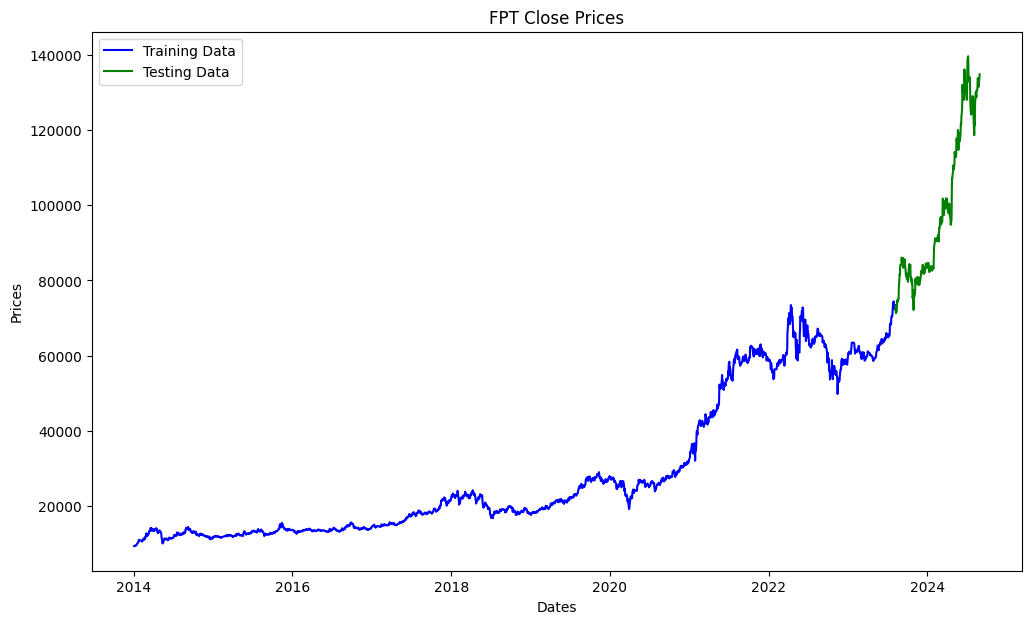

In [65]:
plt.figure(figsize=(12,7))
plt.title('FPT Close Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train, 'blue', label='Training Data')
plt.plot(test, 'green', label='Testing Data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37276.475, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37277.899, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37277.789, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37279.421, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37276.938, Time=0.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.103 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2391
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -18636.237
Date:                Wed, 25 Sep 2024   AIC                          37276.475
Time:                        15:10:34   BIC                          37288.033
Sample:                             0   HQIC                         37280.680
                               - 2391                                  

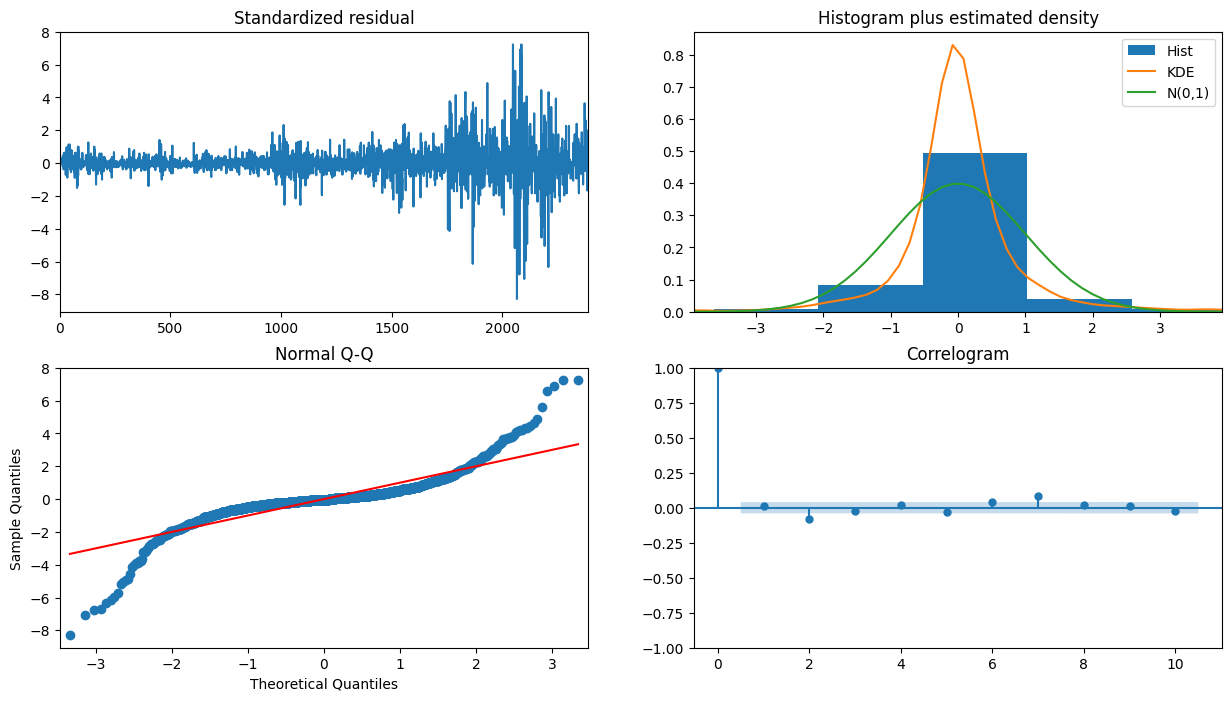

In [66]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [70]:
import statsmodels.api as sm

pred_start = test.index[0]
pred_end = test.index[-1]
model = sm.tsa.statespace.SARIMAX(df_close,order=(0,1,0))
model_fit = model.fit()
pred = model_fit.predict(start= pred_start , end = pred_end)
pred 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06388D+00    |proj g|=  4.87965D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.880D-07   8.064D+00
  F =   8.0638845801253751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


Date
2023-08-08     73478.257812
2023-08-09     73217.390625
2023-08-10     72260.867188
2023-08-11     71478.257812
2023-08-14     71304.351562
                  ...      
2024-08-23    133800.000000
2024-08-26    133100.000000
2024-08-28    131500.000000
2024-08-29    133300.000000
2024-08-30    133700.000000
Name: predicted_mean, Length: 266, dtype: float64

<Axes: xlabel='Date'>

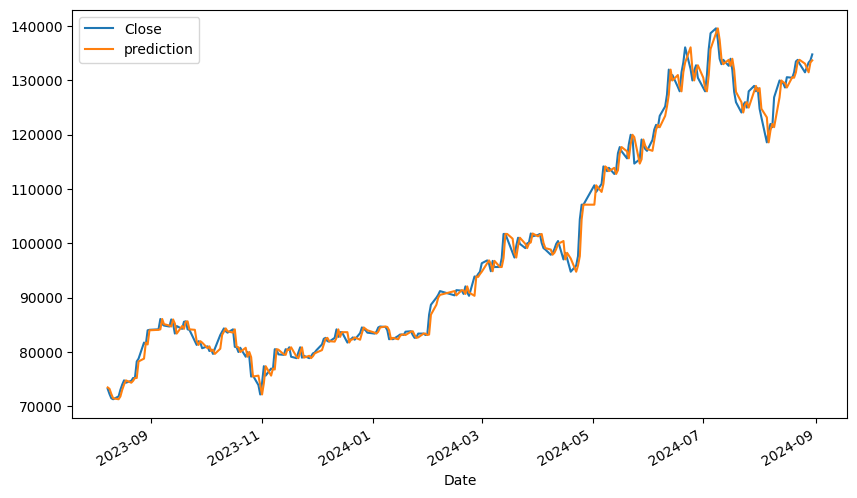

In [71]:
df_sarimax = pd.DataFrame(test)
df_sarimax["prediction"] = pd.Series(pred,index=test.index)
df_sarimax.plot()

In [72]:
df_sarimax

,Close,prediction
Date,,
2023-08-08,73217.390625,73478.257812
2023-08-09,72260.867188,73217.390625
2023-08-10,71478.257812,72260.867188
2023-08-11,71304.351562,71478.257812
2023-08-14,71826.085938,71304.351562
...,...,...
2024-08-23,133100.000000,133800.000000
2024-08-26,131500.000000,133100.000000
2024-08-28,133300.000000,131500.000000


In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = df_sarimax['Close']
y_pred = df_sarimax['prediction']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

In [74]:
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 2814028.846196225
RMSE: 1677.5067350673216
MAE: 1233.9325951597743
